In [2]:
import torch 
from torchvision.models import resnet50, ResNet50_Weights
import argparse

def my_args():
    parser = argparse.ArgumentParser()

    # Optimizer
    parser.add_argument('--lr', type=float, default=3e-5, help='learining rate')
    parser.add_argument('--beta1', type=float, default=0.5 , help='beta1 for adam optimizer')
    parser.add_argument('--beta2', type=float, default=0.999, help='beta2 for adam optimizer')
    parser.add_argument('--diff_model', action='store_true', default=False, help='use diffusion model')

    # training 
    parser.add_argument('--img_size', type=int, default=256, help='Image size')
    parser.add_argument('--in_channels', type=int, default=3, help='input channels')
    parser.add_argument('--img_transforms', type=list, default=["colorjitter",'horizontal_flip','vertical_flip'], help='choose image transforms from normalize,colorjitter,horizontal_flip,grayscale')
    parser.add_argument('--num_epochs', type=int, default=3, help='epoch num')
    parser.add_argument('--decay_epoch', type=int, default=80, help='decay epoch num')
    parser.add_argument('--batch_size', type=int, default=1, help='batch size')
    parser.add_argument('--device', type=str, default="cuda", help='device')

    # Data dirs
    parser.add_argument('--train_data', type=str, default='C:/Users/phili/OneDrive/Uni/WS_22/Masterarbeit/Masterarbeit_Code_Philipp_Rosin/Data_set_BCI_challange/train', help='directory to the train data')
    parser.add_argument('--test_data', type=str, default='C:/Users/phili/OneDrive/Uni/WS_22/Masterarbeit/Masterarbeit_Code_Philipp_Rosin/Data_set_BCI_challange/val', help='directory to the test data')
    

    return parser.parse_args() 


args = my_args()
args = my_args()
net = resnet50()
net.fc = torch.nn.Linear(net.fc.in_features, 4)
torch.nn.init.xavier_uniform_(net.fc.weight)
net = net.to(args.device)

usage: ipykernel_launcher.py [-h] [--lr LR] [--beta1 BETA1] [--beta2 BETA2]
                             [--diff_model] [--img_size IMG_SIZE]
                             [--in_channels IN_CHANNELS]
                             [--img_transforms IMG_TRANSFORMS]
                             [--num_epochs NUM_EPOCHS]
                             [--decay_epoch DECAY_EPOCH]
                             [--batch_size BATCH_SIZE] [--device DEVICE]
                             [--train_data TRAIN_DATA] [--test_data TEST_DATA]
ipykernel_launcher.py: error: unrecognized arguments: --f=c:\Users\phili\AppData\Roaming\jupyter\runtime\kernel-v2-18872Fj20YhY8PhBG.json


SystemExit: 2

In [9]:
import torch 
from sklearn.metrics import confusion_matrix
from pathlib import Path
import os
import numpy as np
import seaborn as sn

x = range(0,6)
y=range(0,6)
cf_matrix = confusion_matrix(np.array(x), np.array(y))

df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
plt.savefig('output.png')
        

ModuleNotFoundError: No module named 'sklearn'

AttributeError: 'numpy.ndarray' object has no attribute 'get_subplotspec'

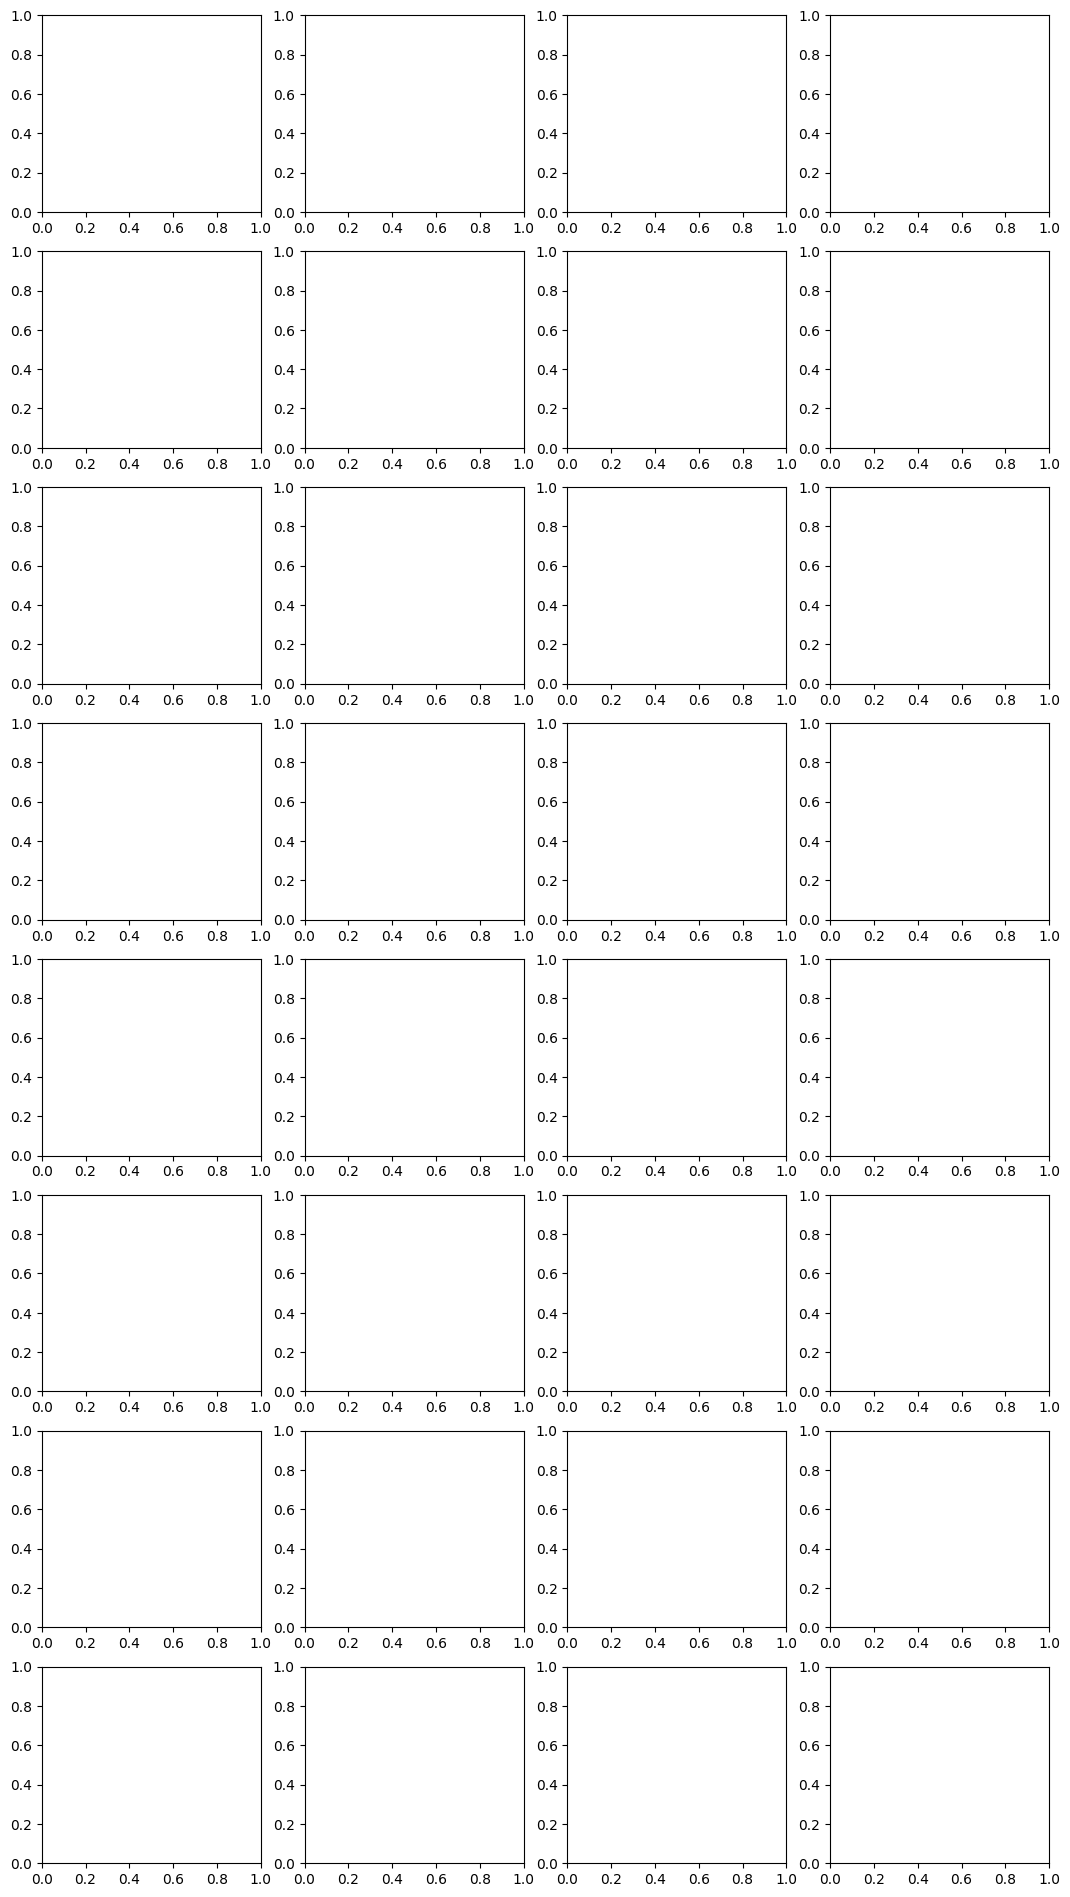

In [2]:
import matplotlib.pyplot as plt
num_rows = 8
num_cols = 4
subplot_size = 3  # Adjust this value to control the size of each subplot
fig_width = subplot_size * num_cols+ 1.0 
fig_height = subplot_size * num_rows 

fig, axes = plt.subplots( num_rows, num_cols, figsize=(fig_width, fig_height))
#print(axes)
for ax in axes:
    sbs = ax.get_subplotspec()
    print(sbs)